In [118]:
#Import
import pandas as pd
import os
from google.colab import drive

import numpy as np #muss nachher weg!
import random #muss nachher weg!

import matplotlib.pyplot as plt
import networkx as nx

In [122]:
# CSV-Dateien laden
output_df = pd.read_csv('/content/drive/MyDrive/output.csv')
data = pd.read_csv('/content/drive/MyDrive/latest_container.csv')

# Spaltennamen bereinigen
output_df.columns = output_df.columns.str.strip()
data.columns = data.columns.str.strip()

# Koordinaten hinzufügen und Adressen aktualisieren
merged_df = data.merge(output_df[['old_adresses', 'Coordinate']], left_on='Adresse', right_on='old_adresses', how='left')

# Adressen überschreiben
merged_df['Adresse'] = merged_df['old_adresses']
merged_df.drop(columns=['old_adresses'], inplace=True)

# Ergebnis anzeigen (nur die ersten 5 Zeilen)
print(merged_df.head(5))

  Container-ID        Stadtteil                       Adresse       Datum  \
0    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-01   
1    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-01   
2    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-01   
3    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-01   
4    KA-0000-W  Aue/Lohn-Lissen  Auer Straße/Hildebrandstraße  2024-01-02   

  Uhrzeit  Füllstand (%)  Containergröße (m³) Container-Typ  \
0   06:00            1.9                  2.5          Weiß   
1   08:00            3.8                  2.5          Weiß   
2   14:00            5.7                  2.5          Weiß   
3   18:00            7.6                  2.5          Weiß   
4   06:00            2.1                  2.5          Weiß   

             Coordinate  
0  49.0082292,8.4032381  
1  49.0082292,8.4032381  
2  49.0082292,8.4032381  
3  49.0082292,8.4032381  
4  49.0082292,8.4032381  


In [130]:
df = merged_df

df['Datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['Uhrzeit'])

df_sorted = df.sort_values(by=['Container-ID', 'Datetime'], ascending=[True, False])

df_latest = df_sorted.drop_duplicates(subset='Container-ID', keep='first')

df_latest = df_latest.drop(columns='Datetime')

df_latest.reset_index(drop=True, inplace=True)

merged_df.dropna(subset=['Coordinate'], inplace=True)

df_latest.to_csv('/content/drive/MyDrive/df_latest.csv', index=False)

print(df_latest.tail(5))

    Container-ID      Stadtteil                                      Adresse  \
615    KA-0615-G  Südwest­stadt              Südend­stra­ße/­Boe­ck­h­straße   
616    KA-0616-B  Südwest­stadt              Südend­stra­ße/­Boe­ck­h­straße   
617    KA-0617-W  Südwest­stadt  Victor-Gollancz-Straße/Schwarz­wald­stra­ße   
618    KA-0618-G  Südwest­stadt  Victor-Gollancz-Straße/Schwarz­wald­stra­ße   
619    KA-0619-B  Südwest­stadt  Victor-Gollancz-Straße/Schwarz­wald­stra­ße   

          Datum Uhrzeit  Füllstand (%)  Containergröße (m³) Container-Typ  \
615  2024-12-31   16:00           74.8                  2.5          Grün   
616  2024-12-31   18:00           96.6                  2.5         Braun   
617  2024-12-31   18:00           49.7                  2.5          Weiß   
618  2024-12-31   20:00          100.0                  2.5          Grün   
619  2024-12-31   20:00          100.0                  2.5         Braun   

               Coordinate  
615  48.9462905,8.4891337  


In [131]:
# Nur Zeilen mit gültigen Koordinaten behalten
output_df_clean = df_latest.dropna(subset=['Coordinate']).reset_index(drop=True)

# Container-IDs und Koordinaten synchron extrahieren
container_ids = output_df_clean['Container-ID'].values
coordinates = output_df_clean['Coordinate'].str.split(',', expand=True)
x = coordinates[0].astype(float).values
y = coordinates[1].astype(float).values

# Beispielkoordinaten anzeigen
print("Beispielkoordinaten:")
print(list(zip(container_ids[:10], x[:10], y[:10])))

Beispielkoordinaten:
[('KA-0000-W', np.float64(49.0082292), np.float64(8.4032381)), ('KA-0001-G', np.float64(49.0082292), np.float64(8.4032381)), ('KA-0002-B', np.float64(49.0082292), np.float64(8.4032381)), ('KA-0003-W', np.float64(49.0038792), np.float64(8.405614)), ('KA-0004-G', np.float64(49.0038792), np.float64(8.405614)), ('KA-0005-B', np.float64(49.0038792), np.float64(8.405614)), ('KA-0006-W', np.float64(49.0040852), np.float64(8.4006776)), ('KA-0007-G', np.float64(49.0040852), np.float64(8.4006776)), ('KA-0008-B', np.float64(49.0040852), np.float64(8.4006776)), ('KA-0009-W', np.float64(49.0070257), np.float64(8.4078911))]


In [132]:
edges = []
weights = []
distances = []

# The loop size is now based on the number of containers with valid coordinates
for i in range(num_containers):
    # Zufälliger Ziel-Container (kein Selbstverweis)
    target = random.randint(0, num_containers - 1)
    while target == i:
        target = random.randint(0, num_containers - 1)

    # Kante hinzufügen
    edges.append((container_ids[i], container_ids[target]))
    weights.append(1)  # Alle Gewichte auf 1 setzen

    # Distanz berechnen
    dx = x[i] - x[target]
    dy = y[i] - y[target]
    distance = round(np.sqrt(dx**2 + dy**2), 5)  # Distanz mit 5 Dezimalstellen
    distances.append(distance)

# Beispiel für die ersten 5 Kanten
print("Beispielkanten:")
print(edges[:10])
print("Beispieldistanzen:")
print(distances[:10])

Beispielkanten:
[('KA-0000-W', 'KA-0043-G'), ('KA-0001-G', 'KA-0243-W'), ('KA-0002-B', 'KA-0059-W'), ('KA-0003-W', 'KA-0059-W'), ('KA-0004-G', 'KA-0197-G'), ('KA-0005-B', 'KA-0078-B'), ('KA-0006-W', 'KA-0153-W'), ('KA-0007-G', 'KA-0281-G'), ('KA-0008-B', 'KA-0205-W'), ('KA-0009-W', 'KA-0289-W')]
Beispieldistanzen:
[np.float64(0.01252), np.float64(0.03677), np.float64(0.01305), np.float64(0.01198), np.float64(0.02792), np.float64(0.02004), np.float64(0.02018), np.float64(0.03912), np.float64(0.03433), np.float64(0.0412)]


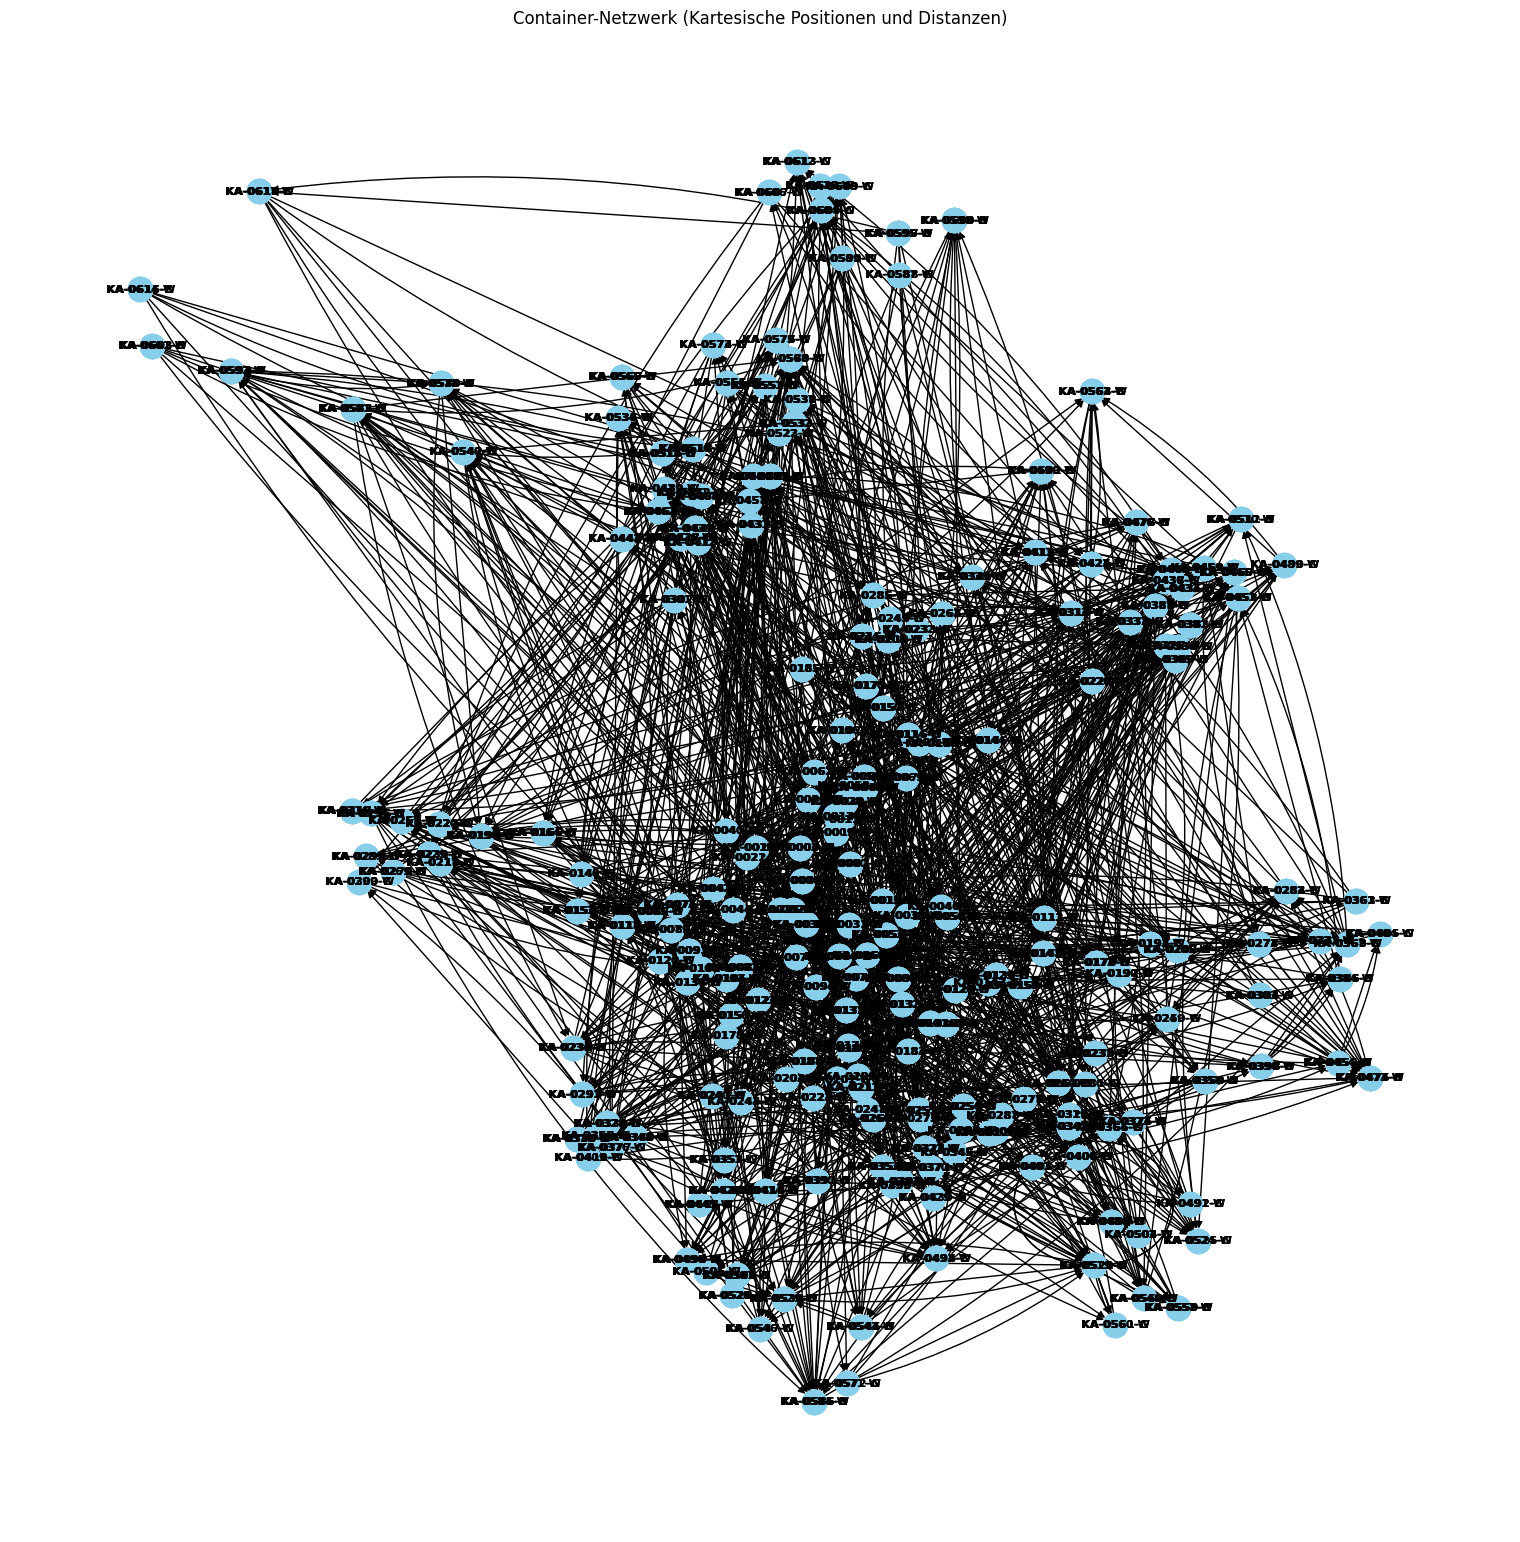

In [133]:
# Netzwerk erstellen
G = nx.DiGraph()
G.add_nodes_from(container_ids)
for i, (source, target) in enumerate(edges):
    G.add_edge(source, target, weight=weights[i], distance=distances[i])

# Netzwerk zeichnen
plt.figure(figsize=(15, 15))
pos = {container_ids[i]: (x[i], y[i]) for i in range(num_containers)}
# Set a simple connectionstyle for drawing edges
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, font_weight='bold', arrows=True, connectionstyle='arc3,rad=0.1')

# Edge-Labels (Distanz)
edge_labels = nx.get_edge_attributes(G, 'distance')
# The edge labels should now be drawn on the arcs created by the specified connectionstyle
# Removed connectionstyle from edge labels draw call to avoid unpacking issue
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, font_weight='bold', arrows=True)

plt.title('Container-Netzwerk (Kartesische Positionen und Distanzen)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()